# Контекст

Необходимо классифицировать текст отзыва ресторана

## Описание данных

Есть фрем подробных метаданных, нам же нужен один признак - text и таргет - stars

In [2]:
import pandas as pd
import numpy as np
import re
import warnings
import joblib
from scipy import sparse

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


warnings.filterwarnings("ignore")
stop_list = stopwords.words('english')
porter = PorterStemmer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Куда ?: ', torch.cuda.is_available())
RANDOM_STATE = 42

Куда ?:  True


# Блок функций / классов (можно держать в отдельном .py файле)

#### функция очистки текстовых данных

In [ ]:
def text_preprocess(stroka):
    stroka = stroka.lower() # нижний регистр
    regex = re.compile(r'[\n\r\t]')
    stroka = regex.sub(' ', stroka) # убрать питоновские переносы строки и т.д.
    # stroka = re.sub(r'([.,!?])', r' \1 ', stroka) 
    stroka = re.sub(r"[^a-zA-Z]+", r" ", stroka) # оставляем слова
    stroka = stroka.translate(str.maketrans('', '', string.punctuation)) # убираем пунктуацию
    stroka = re.sub(" +", " ", stroka).strip() # сброс лишних пробелов
    token_list_bez_stopwords = [word for word in stroka.split() if word not in stop_list] # сброс стоп-слов
    token_stem = [porter.stem(word) for word in token_list_bez_stopwords] # стеммер
    return ' '.join(token_stem)

#### 

In [2]:
pd.read_json('yelp_academic_dataset_review.json', nrows = 5, lines = True) 

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [38]:
chunks = pd.read_json('yelp_academic_dataset_review.json', lines=True, chunksize = 10**6)
data = pd.DataFrame()
for chunk in chunks:
  data = pd.concat([data, chunk])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        int64         
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 480.0+ MB


In [5]:
data.duplicated().sum()

0

Text(0.5, 1.0, 'Распределение кол-ва звезд по заведениям')

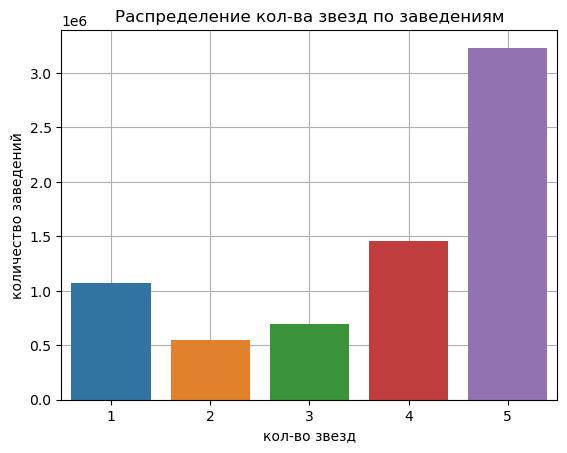

In [6]:
ax =\
sns.countplot(data = data,
              x = 'stars')
plt.grid()
ax.set_axisbelow(b = True)
plt.xlabel('кол-во звезд')
plt.ylabel('количество заведений')
plt.title('Распределение кол-ва звезд по заведениям')

In [7]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour

Text(0.5, 1.0, 'Распределение кол-ва отзывов по годам')

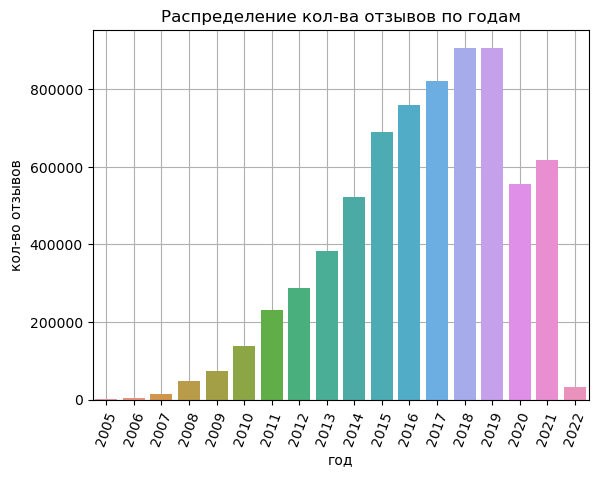

In [8]:
ax =\
sns.countplot(data = data,
              x = 'year')
plt.grid()
ax.set_axisbelow(b = True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
plt.xlabel('год')
plt.ylabel('кол-во отзывов')
plt.title('Распределение кол-ва отзывов по годам')

Text(0.5, 1.0, 'Распределение кол-ва отзывов по месяцам')

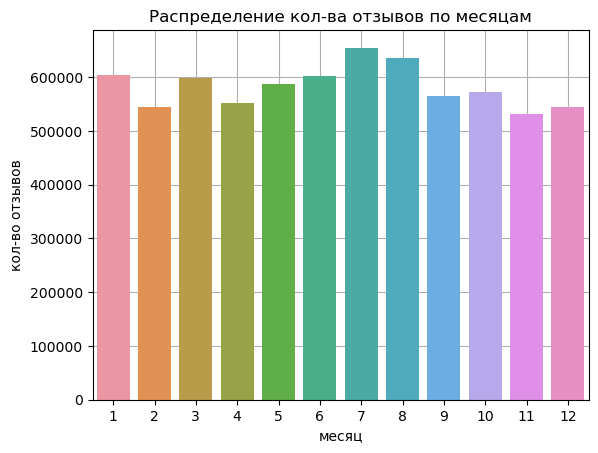

In [9]:
ax =\
sns.countplot(data = data,
              x = 'month')
plt.grid()
ax.set_axisbelow(b = True)
plt.xlabel('месяц')
plt.ylabel('кол-во отзывов')
plt.title('Распределение кол-ва отзывов по месяцам')

Text(0.5, 1.0, 'Распределение кол-ва отзывов по часам')

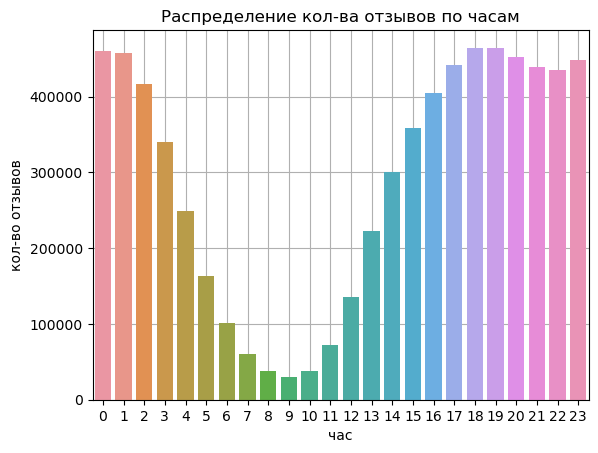

In [10]:
ax =\
sns.countplot(data = data,
              x = 'hour')
plt.grid()
ax.set_axisbelow(b = True)
plt.xlabel('час')
plt.ylabel('кол-во отзывов')
plt.title('Распределение кол-ва отзывов по часам')

In [11]:
reviews = data[['stars', 'text']]
reviews.head()

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
1,5,I've taken a lot of spin classes over the year...
2,3,Family diner. Had the buffet. Eclectic assortm...
3,5,"Wow! Yummy, different, delicious. Our favo..."
4,4,Cute interior and owner (?) gave us tour of up...


In [14]:
X = reviews['text']
y = reviews.drop('text', axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)
X_train, X_val , y_train, y_val = train_test_split(X_train,  y_train,
                                                   test_size = 0.2,
                                                   stratify = y_train,
                                                   random_state = RANDOM_STATE)

In [15]:
train_set = pd.concat([X_train, y_train], axis = 1)
test_set = pd.concat([X_test, y_test], axis = 1)
val_set = pd.concat([X_val, y_val], axis = 1)

train_set.to_json('train_set.json')
test_set.to_json('test_set.json')
val_set.to_json('val_set.json')

In [16]:
train_set = pd.read_json('train_set.json')
val_set = pd.read_json('val_set.json')

In [44]:
# воспользуемся функцией из блока
text_preprocess(train_set['text'].iloc[0])

'doubl special rib steakwith bone perfect tender beauti serv well train staff excel servic staff welcom food fresh hot salad cold wonder hous salad huge portion wonder nice spice overli salti etc ladi room attend excel attent staff everyth clean recommend other'

In [45]:
train_set['text'] = train_set['text'].map(text_preprocess)
val_set['text'] = val_set['text'].map(text_preprocess)

In [46]:
bow_transform = CountVectorizer()
X_train_bow = bow_transform.fit_transform(train_set['text'])
len(bow_transform.vocabulary_)

359195

In [47]:
train_set.to_json('train_set_pr.json')
val_set.to_json('val_set_pr.json')

In [48]:
joblib.dump(bow_transform, "bow_transform.pkl")

['bow_transform.pkl']

# Загружаем

In [2]:
bow_transform = joblib.load('bow_transform.pkl')
bow_transform

CountVectorizer()

In [2]:
train_set = pd.read_json('train_set_pr.json')
val_set = pd.read_json('val_set_pr.json')

In [20]:
train_set

,text,1,2,3,4,5
5021224,Had their double special rib steakwith bone......,0,0,0,1,0
3421017,A first impression makes a lasting impression....,0,0,0,0,1
6792900,DON'T DO IT! RECONSIDER! READ SOME .. of my re...,1,0,0,0,0
4758751,Overpriced for what you get. The salad was di...,0,1,0,0,0
5544141,I rarely book a room at full price through the...,0,1,0,0,0
...,...,...,...,...,...,...
4356352,We stopped here for breakfast and loved the sm...,0,0,0,1,0
5320221,I rang this place up at 9:40 p.m. (20 minutes ...,0,0,0,1,0
1050893,Great place if you want to spend $100 and be i...,0,1,0,0,0
501926,Very good italian food. My husband and I came ...,0,0,0,1,0


In [4]:
y_train = train_set['stars']
y_val = val_set['stars']

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_trfm = TfidfVectorizer()


X_train_tfidf = tfidf_trfm.fit_transform(train_set['text'])
X_val_tfidf = tfidf_trfm.transform(val_set['text'])

In [4]:
X_train_tfidf

<4473779x359195 sparse matrix of type '<class 'numpy.float64'>'
	with 191867040 stored elements in Compressed Sparse Row format>

In [5]:
joblib.dump(tfidf_trfm, "tfidf_transform.pkl")

['tfidf_transform.pkl']

In [9]:
from scipy import sparse

sparse.save_npz('train_features.npz', X_train_tfidf)
sparse.save_npz('val_features.npz', X_val_tfidf)

In [10]:
X_train_tfidf = sparse.load_npz('train_features.npz')
X_val_tfidf = sparse.load_npz('val_features.npz')

In [11]:
X_train_tfidf

<4473779x359195 sparse matrix of type '<class 'numpy.float64'>'
	with 191867040 stored elements in Compressed Sparse Row format>

In [29]:
y_train.reset_index()

,index,stars
0,5021224,4
1,3421017,5
2,6792900,1
3,4758751,2
4,5544141,2
...,...,...
4473774,4356352,4
4473775,5320221,4
4473776,1050893,2
4473777,501926,4


In [32]:
y_train.reset_index().to_csv('train_target.csv', index = False, header = True)
y_val.reset_index().to_csv('val_target.csv', index = False, header = True)

# Загружаем

In [40]:
tfidf_trfm = joblib.load('tfidf_transform.pkl')

In [71]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import (random, 
                          coo_matrix,
                          csr_matrix, 
                          vstack)


def sparse_coo_to_tensor(coo):
    """
    цель: переместить scipy.coo (на выходе у TFIDFVectorizer) --> float_tenzor_pytorch
    """
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    shape = coo.shape

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    s = torch.Size(shape)

    return torch.sparse.FloatTensor(i, v, s)

def sparse_batch_collate(batch:list): 
    """
    Функция для DataLoader(collate_fn = 'наша функция')
    """
    data_batch, targets_batch = zip(*batch)
    if type(data_batch[0]) == csr_matrix:
        data_batch = vstack(data_batch).tocoo()
        data_batch = sparse_coo_to_tensor(data_batch)
    else:
        data_batch = torch.FloatTensor(data_batch)

    if type(targets_batch[0]) == csr_matrix:
        targets_batch = vstack(targets_batch).tocoo()
        targets_batch = sparse_coo_to_tensor(targets_batch)
    else:
        targets_batch = torch.FloatTensor(targets_batch)
    return data_batch, targets_batch


In [78]:
from sklearn.preprocessing import LabelEncoder


pr = pd.read_json('train_set_pr.json')
encoder = LabelEncoder()
new = encoder.fit_transform(pr['stars'])

In [5]:
new

array([3, 4, 0, ..., 1, 3, 4], dtype=int64)

In [79]:
tfidf_trfm = joblib.load("tfidf_transform.pkl")

from sklearn.preprocessing import LabelEncoder

class ReviewDataset(Dataset):
    def __init__(self, file_path):
        # data loading
        self.file_path = file_path

        xy = pd.read_json(file_path)
        self.x = tfidf_trfm.transform(xy['text'])
        self.y = encoder.transform(xy['stars'])
        self.n_samples = xy.shape[0]

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [80]:
train_dataset = ReviewDataset(
    file_path = 'train_set_pr.json'
)

val_dataset = ReviewDataset(
    file_path = 'val_set_pr.json'
)


train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 128,
    collate_fn = sparse_batch_collate
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 128,
    collate_fn = sparse_batch_collate
)

In [81]:
num_features = len(tfidf_trfm.vocabulary_)

model = nn.Sequential(
    nn.Linear(in_features = num_features, out_features = 5)
)

In [82]:
torch.tensor(train_dataloader.dataset[0][0].toarray())

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [9]:
matrix = torch.tensor(train_dataloader.dataset[0][0].toarray(), dtype = torch.float32)
print('Количество признаков: ' , matrix.shape[1])
print('Размерность словаря TF-IDF: ', num_features)
model = model.cuda()
logists = model(matrix.to(device))
print('Возвращаемые моделью логиты: {}, \nВероятность после softmax: {}'.format(logists[0].detach().cpu().numpy(), torch.softmax(logists, dim = 1)[0].detach().cpu().numpy()))

Количество признаков:  359195
Размерность словаря TF-IDF:  359195
Возвращаемые моделью логиты: [-0.00149574  0.00082906 -0.00111385 -0.00170133 -0.00112257], 
Вероятность после softmax: [0.19988498 0.20035021 0.19996132 0.1998439  0.19995959]


In [10]:
loss_fn = nn.CrossEntropyLoss()

X, y = train_dataloader.dataset[0:2][0], train_dataloader.dataset[0:2][1]
X = torch.tensor(X.toarray(),  dtype = torch.float32).to(device)
y = torch.tensor(y).to(device)
y_pred = model(X)
y_pred

tensor([[-0.0015,  0.0008, -0.0011, -0.0017, -0.0011],
        [-0.0006,  0.0010, -0.0029,  0.0005, -0.0003]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [24]:
torch.tensor(y, dtype = torch.long)

tensor([3, 4], device='cuda:0')

In [25]:
loss_fn(y_pred, y)

tensor(1.6098, device='cuda:0', grad_fn=<NllLossBackward0>)

Epoch 1/10,  train loss: 1.035, test_loss: 0.917, train accuracy: 0.591, test accuracy: 0.640
Epoch 10/10,  train loss: 0.776, test_loss: 0.776, train accuracy: 0.683, test accuracy: 0.682


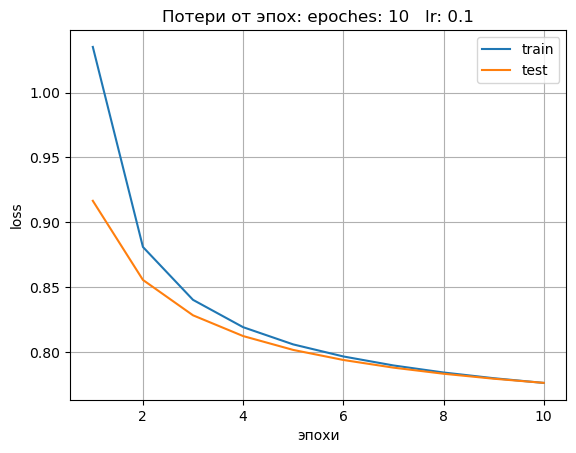

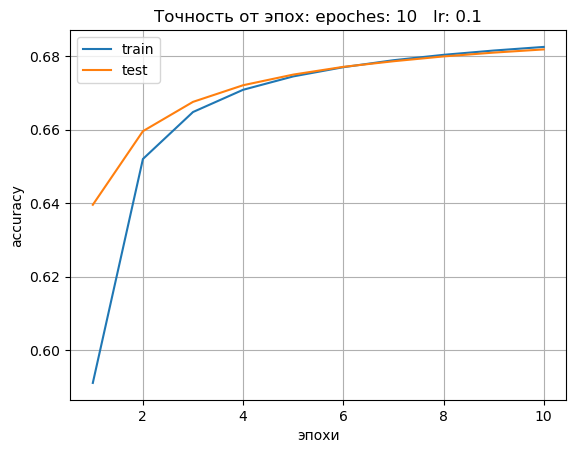

In [29]:
loss_train_list = []
loss_test_list = []
accuracy_train_list = []
accuracy_test_list = []

epoches = 10
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
train_loader = train_dataloader
test_loader = val_dataloader

for epoch in range(1, epoches+1):

        loss_train = 0
        loss_test = 0

        correct_train = 0
        total_train = 0

        correct_test = 0
        total_test = 0

        for imgs, labels in train_loader:
            
            model.train()
            imgs = imgs.cuda()
            labels = labels.cuda()
            labels = labels.to(torch.long)
            outputs = model(imgs)

            # Тренировочный потери
            loss = loss_fn(outputs, labels)

            # loss_reg = loss_with_l1_or_l2_regulizer(type = type_reg, l_lambda = 0.001, loss_by_fn = loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

            _, predicted = torch.max(outputs, dim = 1)
            total_train += labels.shape[0]
            correct_train += ((predicted == labels).sum())


        mean_epoch_loss = loss_train/len(train_loader)
        loss_train_list.append(mean_epoch_loss)

        train_accuracy_value = correct_train / total_train
        accuracy_train_list.append(train_accuracy_value.item())

    # Проверочный этап
        model.eval()
        with torch.no_grad():
                for imgs, labels in test_loader:
                        imgs = imgs.cuda()
                        labels = labels.type(torch.LongTensor).cuda()
                        outputs = model(imgs)
                        loss_on_test = loss_fn(outputs, labels)
                        loss_test += loss_on_test.item()

                        _, predicted = torch.max(outputs, dim = 1)
                        total_test += labels.shape[0]
                        correct_test += ((predicted == labels).sum())
                

                test_accuracy_value = correct_test / total_test
                accuracy_test_list.append(test_accuracy_value.item())

                mean_epoch_loss_test = loss_test / len(test_loader)
                loss_test_list.append(mean_epoch_loss_test)

        if epoch == 1 or epoch % 10 == 0:
            print(
                    'Epoch {}/{},  train loss: {:.3f}, test_loss: {:.3f}, train accuracy: {:.3f}, test accuracy: {:.3f}'\
                    

                    .format(epoch,
                            epoches,
                            mean_epoch_loss,
                            mean_epoch_loss_test,
                            train_accuracy_value,
                            test_accuracy_value)     
                )

#    
sns.lineplot(x = range(1, epoches+1),
            y = loss_train_list,
            label = 'train')
plt.xlabel('эпохи')
plt.ylabel('loss')
plt.title('Потери от эпох: epoches: {}   lr: {}'.format(epoches,
                                                    optimizer.param_groups[0]['lr']))
sns.lineplot(x = range(1, epoches+1),
            y = loss_test_list,
            label = 'test')
plt.legend()
plt.grid()
plt.show()

#
sns.lineplot(x = range(1, epoches+1),
            y = accuracy_train_list,
            label = 'train')
plt.xlabel('эпохи')
plt.ylabel('accuracy')
plt.title('Точность от эпох: epoches: {}   lr: {}'.format(epoches,
                                                        optimizer.param_groups[0]['lr']))
sns.lineplot(x = range(1, epoches+1),
            y = accuracy_test_list,
            label = 'test')
plt.legend()
plt.grid()
plt.show()

---

In [147]:
little_df = pd.read_json('train_set_pr.json')[:2000]

# one_hot_stars = pd.get_dummies(little_df['stars'], dtype = float)
# little_df = pd.concat([little_df.drop('stars', axis = 1), one_hot_stars], axis = 1)

little_train_df = little_df[:1000]
little_val_df = little_df[1000:2000]

little_train_df.to_json('little_train_df.json')
little_val_df.to_json('little_val_df.json')

# ЗДЕСЬ

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import (random, 
                          coo_matrix,
                          csr_matrix, 
                          vstack)


def sparse_coo_to_tensor(coo):
    """
    цель: переместить scipy.coo (на выходе у TFIDFVectorizer) --> float_tenzor_pytorch
    """
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    shape = coo.shape

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    s = torch.Size(shape)

    return torch.sparse.FloatTensor(i, v, s)

def sparse_batch_collate(batch:list): 
    """
    Функция для DataLoader(collate_fn = 'наша функция')
    """
    data_batch, targets_batch = zip(*batch)
    if type(data_batch[0]) == csr_matrix:
        data_batch = vstack(data_batch).tocoo()
        data_batch = sparse_coo_to_tensor(data_batch)
    else:
        data_batch = torch.FloatTensor(data_batch)

    if type(targets_batch[0]) == csr_matrix:
        targets_batch = vstack(targets_batch).tocoo()
        targets_batch = sparse_coo_to_tensor(targets_batch)
    else:
        targets_batch = torch.FloatTensor(targets_batch)
    return data_batch, targets_batch


In [3]:
from sklearn.preprocessing import OneHotEncoder

class Vectorizer():
    def __init__(self,
                 max_features=None,
                 # stop_words=None,
                 # type_dataset = 'train'
                 ):

        self.max_features = max_features
        self.tfidf = TfidfVectorizer(max_features=self.max_features)
        self.onh = OneHotEncoder()
    
    def _set_tfidf(self,cleaned_texts):
        self.tfidf.fit(cleaned_texts)
        return self.tfidf
    
    # def build_vectorizer(self,texts):
    #     self._set_tfidf(texts)
        
    def vectorizeTexts(self,texts):
        return self.tfidf.transform(texts)
    
    def one_hot_encoding_fitter(self, labels_column):
        self.onh.fit(labels_column)
        return self.onh
    
    def one_hot_encoding_transformer(self, labels_column):
        return self.onh.transform(labels_column)



class TRAIN___ReviewDatasetVectorizer(Dataset):
    def __init__(self,
                 file_path, # '_____.json'
                 tfidf_max_features):
        
        self.file_path = file_path
        self.tfidf_max_features = tfidf_max_features

        # data loading
        xy = pd.read_json(file_path)
        y = xy.drop('text', axis = 1).values
        

        self.tfidf_encoder = Vectorizer(max_features = tfidf_max_features)._set_tfidf(xy['text'])
        self.onh_encoder = Vectorizer(max_features = tfidf_max_features).one_hot_encoding_fitter(y)
        self.x = self.tfidf_encoder.transform(xy['text'])
        self.y = self.onh_encoder.transform(y).toarray()
        self.n_samples = xy.shape[0]

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def get_tfidf_encoder(self):
        return self.tfidf_encoder
    
    def get_onh_encoder(self):
        return self.onh_encoder



class VAL___ReviewDatasetVectorizer(Dataset):
    def __init__(self,
                 file_path, # '_____.json'
                 encoder_TF__IDF,
                 onh_encoder):
        
        self.file_path = file_path
        self.encoder_TF__IDF = encoder_TF__IDF
        self.onh_encoder = onh_encoder

        # data loading
        xy = pd.read_json(file_path)
        x = xy['text']
        y = xy.drop('text', axis = 1).values
        

        self.x = self.encoder_TF__IDF.transform(x)
        self.y = self.onh_encoder.transform(y).toarray()
        self.n_samples = xy.shape[0]

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]




def dataloader_preprocess(
        file_path_train,
        file_path_val,
        tfidf_max_features,
        batch_size
):
    # Подготовка словаря

    dataset_train = TRAIN___ReviewDatasetVectorizer(
                            file_path = file_path_train,
                            tfidf_max_features = tfidf_max_features
                            )
    
    tfidf_encoder = dataset_train.get_tfidf_encoder()
    onh_encoder = dataset_train.get_onh_encoder()

    train_dataloader = DataLoader(
                        dataset = dataset_train,
                        batch_size = batch_size,
                        collate_fn = sparse_batch_collate
                           )
    

    val_dataloader = DataLoader(
                        dataset = VAL___ReviewDatasetVectorizer(
                            file_path = file_path_val,
                            encoder_TF__IDF = tfidf_encoder,
                            onh_encoder = onh_encoder),
                        batch_size = batch_size,
                        collate_fn = sparse_batch_collate
                           )
    
    return train_dataloader, val_dataloader

In [151]:
train_dataloader, val_dataloader = dataloader_preprocess(
    file_path_train = 'little_train_df.json',
    file_path_val = 'little_val_df.json',
    tfidf_max_features = 2000,
    batch_size = 128
)

In [152]:
num_features = train_dataloader.dataset[0][0].shape[1]

model = nn.Sequential(
    nn.Linear(in_features = num_features, out_features = 5)
)

model = model.to(device)
num_features

2000

In [153]:
values = train_dataloader.dataset[0:2][0].toarray()
values = torch.tensor(values, dtype = torch.float32).to(device)
values

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0760, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [158]:
targets = train_dataloader.dataset[0:2][1].toarray()
targets = torch.tensor(targets, dtype = torch.float32).to(device)
targets

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], device='cuda:0')

In [159]:
predict_logits = model(values)
predict_logits

tensor([[-0.0292, -0.0146,  0.0170, -0.0186, -0.0089],
        [-0.0385, -0.0015,  0.0281, -0.0053,  0.0236]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [160]:
predict_probas = torch.softmax(predict_logits, dim = 1)
predict_probas

tensor([[0.1963, 0.1992, 0.2056, 0.1984, 0.2004],
        [0.1921, 0.1994, 0.2054, 0.1986, 0.2045]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [161]:
values, indexes = torch.max(torch.softmax(predict_logits, dim = 1), dim = 1)
indexes

tensor([2, 2], device='cuda:0')

In [162]:
loss_fn = nn.CrossEntropyLoss()
loss_fn(predict_logits, targets)

tensor(1.6023, device='cuda:0', grad_fn=<DivBackward1>)

 под нижний loop и потренировать на dataloader (little_......)


1) предсказать в валидации
2) нарисовать таблицу неточностей одновременно для всех классов
3) 
) проверить результаты при балансировке классов



Epoch 1/10, train loss: 1.549, test_loss: 1.474
Epoch 2/10, train loss: 1.374, test_loss: 1.394
Epoch 3/10, train loss: 1.261, test_loss: 1.347
Epoch 4/10, train loss: 1.173, test_loss: 1.312
Epoch 5/10, train loss: 1.095, test_loss: 1.281
Epoch 6/10, train loss: 1.024, test_loss: 1.254
Epoch 7/10, train loss: 0.958, test_loss: 1.231
Epoch 8/10, train loss: 0.899, test_loss: 1.212
Epoch 9/10, train loss: 0.845, test_loss: 1.196
Epoch 10/10, train loss: 0.796, test_loss: 1.182


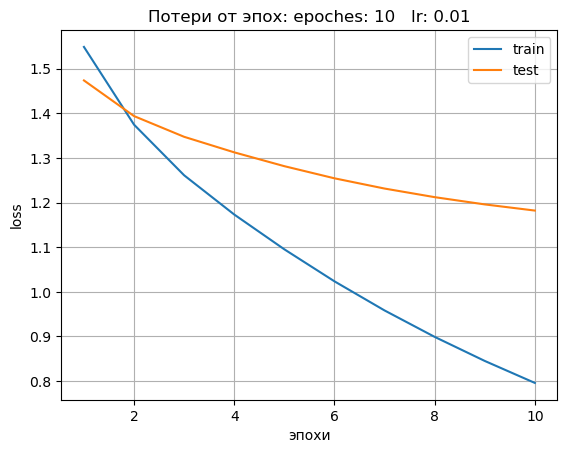

In [13]:

loss_train_list = []
loss_test_list = []
# ROC_AUC_train_list = []
# ROC_AUC_test_list = []

epoches = 10
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
train_loader = train_dataloader
test_loader = val_dataloader

for epoch in range(1, epoches+1):

        loss_train = 0
        loss_test = 0

        correct_train = 0
        total_train = 0

        correct_test = 0
        total_test = 0

        for imgs, labels in train_loader:
            
            model.train()
            imgs = imgs.cuda()
            labels = labels.cuda()
            # labels = labels.to(torch.long)
            outputs = model(imgs)

            # Тренировочный потери
            loss = loss_fn(outputs, labels)

            # loss_reg = loss_with_l1_or_l2_regulizer(type = type_reg, l_lambda = 0.001, loss_by_fn = loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

            '''_, predicted = torch.max(torch.softmax(outputs, dim = 1), dim = 1)
            total_train += labels.shape[0]
            correct_train += ((predicted == labels).sum())
'''

        mean_epoch_loss = loss_train/len(train_loader)
        loss_train_list.append(mean_epoch_loss)

        '''train_accuracy_value = correct_train / total_train
        accuracy_train_list.append(train_accuracy_value.item())'''

        # Проверочный этап
        model.eval()
        with torch.no_grad():
                for imgs, labels in test_loader:
                        imgs = imgs.cuda()
                        labels = labels.cuda()
                        outputs = model(imgs)
                        loss_on_test = loss_fn(outputs, labels)
                        loss_test += loss_on_test.item()

                        '''_, predicted = torch.max(outputs, dim = 1)
                        total_test += labels.shape[0]
                        correct_test += ((predicted == labels).sum())'''
                

                '''test_accuracy_value = correct_test / total_test
                accuracy_test_list.append(test_accuracy_value.item())'''

                mean_epoch_loss_test = loss_test / len(test_loader)
                loss_test_list.append(mean_epoch_loss_test)

        # if epoch == 1 or epoch % 10 == 0:
        print(
                    'Epoch {}/{}, train loss: {:.3f}, test_loss: {:.3f}'
                    .format(epoch,
                            epoches,
                            mean_epoch_loss,
                            mean_epoch_loss_test,
                            # train_accuracy_value,
                            # test_accuracy_value
                            )     
                )
  
sns.lineplot(x = range(1, epoches+1),
            y = loss_train_list,
            label = 'train')
plt.xlabel('эпохи')
plt.ylabel('loss')
plt.title('Потери от эпох: epoches: {}   lr: {}'.format(epoches,
                                                    optimizer.param_groups[0]['lr']))
sns.lineplot(x = range(1, epoches+1),
            y = loss_test_list,
            label = 'test')
plt.legend()
plt.grid()
plt.show()

#
# sns.lineplot(x = range(1, epoches+1),
#             y = accuracy_train_list,
#             label = 'train')
# plt.xlabel('эпохи')
# plt.ylabel('accuracy')
# plt.title('Точность от эпох: epoches: {}   lr: {}'.format(epoches,
#                                                         optimizer.param_groups[0]['lr']))
# sns.lineplot(x = range(1, epoches+1),
#             y = accuracy_test_list,
#             label = 'test')
# plt.legend()
# plt.grid()
# plt.show()

In [14]:
logits_predict = model(torch.tensor(val_dataloader.dataset[:][0].toarray(), dtype = torch.float32).to(device))
logits_predict

tensor([[-0.9706, -1.0865, -0.8164, -0.3117,  0.4851],
        [-2.0084, -1.1669, -1.0220,  0.2043,  0.7423],
        [-1.2070, -0.9553, -0.7748, -0.0174,  0.6759],
        ...,
        [-0.7393, -0.4945, -0.6945, -0.0257,  0.0215],
        [-1.5014, -1.4277, -1.1559,  0.0316,  0.1666],
        [-1.0927, -1.0719, -1.1369, -0.2111,  0.9661]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [15]:
values, indexes = torch.max(torch.softmax(logits_predict, dim = 1), dim = 1)
indexes = indexes.reshape(-1,1)

In [28]:
y_true = np.argmax(val_dataloader.dataset[:][1], axis = 1).reshape(-1,1)

In [17]:
(indexes.cpu().numpy() == y_true).sum()

540

In [18]:
confusion_matrix(y_pred = indexes.cpu().numpy(),
                 y_true = y_true)

array([[ 85,   1,   0,   9,  58],
       [ 10,   0,   3,  13,  60],
       [  3,   1,   2,  28,  65],
       [  1,   0,   1,  41, 181],
       [  2,   0,   0,  24, 412]], dtype=int64)

# Активировать 

In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import (random, 
                          coo_matrix,
                          csr_matrix, 
                          vstack)


def sparse_coo_to_tensor(coo):
    """
    цель: переместить scipy.coo (на выходе у TFIDFVectorizer) --> float_tenzor_pytorch
    """
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    shape = coo.shape

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    s = torch.Size(shape)

    return torch.sparse.FloatTensor(i, v, s)

def sparse_batch_collate(batch:list): 
    """
    Функция для DataLoader(collate_fn = 'наша функция')
    """
    data_batch, targets_batch = zip(*batch)
    if type(data_batch[0]) == csr_matrix:
        data_batch = vstack(data_batch).tocoo()
        data_batch = sparse_coo_to_tensor(data_batch)
    else:
        data_batch = torch.FloatTensor(data_batch)

    if type(targets_batch[0]) == csr_matrix:
        targets_batch = vstack(targets_batch).tocoo()
        targets_batch = sparse_coo_to_tensor(targets_batch)
    else:
        targets_batch = torch.FloatTensor(targets_batch)
    return data_batch, targets_batch


In [5]:
from sklearn.preprocessing import OneHotEncoder

class Vectorizer():
    def __init__(self,
                 max_features=None,
                 # stop_words=None,
                 # type_dataset = 'train'
                 ):

        self.max_features = max_features
        self.tfidf = TfidfVectorizer(max_features=self.max_features)
        self.onh = OneHotEncoder()
    
    def _set_tfidf(self,cleaned_texts):
        self.tfidf.fit(cleaned_texts)
        return self.tfidf
    
    # def build_vectorizer(self,texts):
    #     self._set_tfidf(texts)
        
    def vectorizeTexts(self,texts):
        return self.tfidf.transform(texts)
    
    def one_hot_encoding_fitter(self, labels_column):
        self.onh.fit(labels_column)
        return self.onh
    
    def one_hot_encoding_transformer(self, labels_column):
        return self.onh.transform(labels_column)



class TRAIN___ReviewDatasetVectorizer(Dataset):
    def __init__(self,
                 file_path, # '_____.json'
                 tfidf_max_features):
        
        self.file_path = file_path
        self.tfidf_max_features = tfidf_max_features

        # data loading
        xy = pd.read_json(file_path)
        y = xy.drop('text', axis = 1).values
        

        self.tfidf_encoder = Vectorizer(max_features = tfidf_max_features)._set_tfidf(xy['text'])
        self.onh_encoder = Vectorizer(max_features = tfidf_max_features).one_hot_encoding_fitter(y)
        self.x = self.tfidf_encoder.transform(xy['text'])
        self.y = self.onh_encoder.transform(y).toarray()
        self.n_samples = xy.shape[0]

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def get_tfidf_encoder(self):
        return self.tfidf_encoder
    
    def get_onh_encoder(self):
        return self.onh_encoder



class VAL___ReviewDatasetVectorizer(Dataset):
    def __init__(self,
                 file_path, # '_____.json'
                 encoder_TF__IDF,
                 onh_encoder):
        
        self.file_path = file_path
        self.encoder_TF__IDF = encoder_TF__IDF
        self.onh_encoder = onh_encoder

        # data loading
        xy = pd.read_json(file_path)
        x = xy['text']
        y = xy.drop('text', axis = 1).values
        

        self.x = self.encoder_TF__IDF.transform(x)
        self.y = self.onh_encoder.transform(y).toarray()
        self.n_samples = xy.shape[0]

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]




def dataloader_preprocess(
        file_path_train,
        file_path_val,
        tfidf_max_features,
        batch_size
):
    # Подготовка словаря

    dataset_train = TRAIN___ReviewDatasetVectorizer(
                            file_path = file_path_train,
                            tfidf_max_features = tfidf_max_features
                            )
    
    tfidf_encoder = dataset_train.get_tfidf_encoder()
    onh_encoder = dataset_train.get_onh_encoder()

    train_dataloader = DataLoader(
                        dataset = dataset_train,
                        batch_size = batch_size,
                        collate_fn = sparse_batch_collate
                           )
    

    val_dataloader = DataLoader(
                        dataset = VAL___ReviewDatasetVectorizer(
                            file_path = file_path_val,
                            encoder_TF__IDF = tfidf_encoder,
                            onh_encoder = onh_encoder),
                        batch_size = batch_size,
                        collate_fn = sparse_batch_collate
                           )
    
    return train_dataloader, val_dataloader

In [6]:
def confusion_matrix_plot(
                model,
                val_dataloader
):

        y_pred_spisok_ = []
        model.eval()
        with torch.no_grad():
                for features, labels in val_dataloader:
                                                features = features.cuda()
                                                labels = labels.cuda()
                                                outputs = model(features)
                                                vaules, indexes = torch.max(torch.softmax(outputs, dim = 1), dim = 1)
                                                y_pred = indexes.cpu().numpy()
                                                y_pred_spisok_.append(y_pred)

        y_pred = \
        np.concatenate((np.array(y_pred_spisok_[:-1]).reshape(-1,1),
                        np.array(y_pred_spisok_[-1]).reshape(-1,1)), axis = 0)

        y_true = np.argmax(val_dataloader.dataset[:][1], axis = 1).reshape(-1,1)

        matrix = confusion_matrix(
                y_true = y_true,
                y_pred = y_pred
        )


        matrix = pd.DataFrame(
        matrix,
        columns = ['прогноз {}'.format(i) for i in range(0,5)],
        index = ['фактически {}'.format(i) for i in range(0,5)]
        )

        ax =\
        sns.heatmap(matrix,
                        cmap = 'PiYG', # цветовая гамма
                        cbar = True,   # отключить бар справа
                        annot = True, # показывать числа
                        fmt= ''
        )
        plt.title('Матрица неточностей классификатора \n \n')
        ax.xaxis.tick_top()
        plt.show()


confusion_matrix_plot(model, val_dataloader)

In [7]:
def training_loop(
        epoches,
        model,
        optimizer,
        loss_fn,
        train_dataloader,
        val_dataloader
        ):
    
#     train_dataloader, val_dataloader = dataloader_preprocess(
#         file_path_train = 'little_train_df.json',
#         file_path_val = 'little_val_df.json',
#         tfidf_max_features = 2000,
#         batch_size = 128
#                                                              )
    
    # num_features = train_dataloader.dataset[0][0].shape[1]
    loss_train_list = []
    loss_test_list = []
    # ROC_AUC_train_list = []
    # ROC_AUC_test_list = []

    # epoches = 10
    # optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    model = model.cuda()
    # loss_fn = nn.CrossEntropyLoss()

    for epoch in range(1, epoches+1):

            loss_train = 0
            loss_test = 0

            # correct_train = 0
            # total_train = 0

            # correct_test = 0
            # total_test = 0

            for features, labels in train_dataloader:
                
                model.train()
                features = features.cuda()
                labels = labels.cuda()
                # labels = labels.to(torch.long)
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels)

                # loss_reg = loss_with_l1_or_l2_regulizer(type = type_reg, l_lambda = 0.001, loss_by_fn = loss)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()

                '''_, predicted = torch.max(torch.softmax(outputs, dim = 1), dim = 1)
                total_train += labels.shape[0]
                correct_train += ((predicted == labels).sum())
    '''

            mean_epoch_loss = loss_train/len(train_dataloader)
            loss_train_list.append(mean_epoch_loss)

            '''train_accuracy_value = correct_train / total_train
            accuracy_train_list.append(train_accuracy_value.item())'''

            # Проверочный этап
            model.eval()
            with torch.no_grad():
                    for features, labels in val_dataloader:
                            features = features.cuda()
                            labels = labels.cuda()
                            outputs = model(features)
                            loss_on_test = loss_fn(outputs, labels)
                            loss_test += loss_on_test.item()

                            '''_, predicted = torch.max(outputs, dim = 1)
                            total_test += labels.shape[0]
                            correct_test += ((predicted == labels).sum())'''
                    

                    '''test_accuracy_value = correct_test / total_test
                    accuracy_test_list.append(test_accuracy_value.item())'''

                    mean_epoch_loss_test = loss_test / len(val_dataloader)
                    loss_test_list.append(mean_epoch_loss_test)

            if epoch == 1 or epoch % 10 == 0:
                print(
                        'Epoch {}/{}, train loss: {:.3f}, val_loss: {:.3f}'
                        .format(epoch,
                                epoches,
                                mean_epoch_loss,
                                mean_epoch_loss_test,
                                # train_accuracy_value,
                                # test_accuracy_value
                                )     
                    )
    
    sns.lineplot(x = range(1, epoches+1),
                y = loss_train_list,
                label = 'train')
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.title('Потери от эпох: epoches: {}   lr: {}'.format(epoches,
                                                        optimizer.param_groups[0]['lr']))
    sns.lineplot(x = range(1, epoches+1),
                y = loss_test_list,
                label = 'val')
    plt.legend()
    plt.grid()
    plt.show()

    #
    # sns.lineplot(x = range(1, epoches+1),
    #             y = accuracy_train_list,
    #             label = 'train')
    # plt.xlabel('эпохи')
    # plt.ylabel('accuracy')
    # plt.title('Точность от эпох: epoches: {}   lr: {}'.format(epoches,
    #                                                         optimizer.param_groups[0]['lr']))
    # sns.lineplot(x = range(1, epoches+1),
    #             y = accuracy_test_list,
    #             label = 'test')
    # plt.legend()
    # plt.grid()
    # plt.show()
    
    return model

In [ ]:
train_dataloader, val_dataloader = dataloader_preprocess(
        file_path_train = 'train.json',
        file_path_val = 'val.json',
        tfidf_max_features = 1000,
        batch_size = 128
        )
num_features = train_dataloader.dataset[0][0].shape[1]

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = 5)
    )

training_loop(
    epoches = 10,
    model = model,
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.1),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader    
)

In [8]:
model = torch.load('models\model__tfidf_7000___epoch_10___Adam___lr_0.01.pth')


train_dataloader, val_dataloader = dataloader_preprocess(
    file_path_train = 'train_set_pr.json',
    file_path_val = 'val_set_pr.json',
    tfidf_max_features = 7000,
    batch_size = 128
)